In [9]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from scipy.io import loadmat
from pandas import DataFrame
import glob
import scipy.signal as spsig
from sklearn import preprocessing
import pandas as pd
import csv
from tqdm import tqdm


In [2]:
mat = loadmat('data/Pat1Train/Pat1Train_1_1.mat')

In [3]:
data = mat['data']
data

array([[ 19.369873 ,  -1.5776367, -41.794434 , ...,  62.809326 ,
         46.628662 , -18.094238 ],
       [ 23.331055 ,  -4.599121 , -36.759033 , ...,  70.79883  ,
         48.575684 , -17.087158 ],
       [ 25.345215 , -10.574463 , -34.744873 , ...,  84.831055 ,
         52.604004 , -17.087158 ],
       ...,
       [-15.610107 , -36.624756 ,  21.182617 , ..., -25.07666  ,
        -11.312988 ,  30.85083  ],
       [-24.60669  , -28.63501  ,  19.168457 , ..., -28.0979   ,
        -12.320068 ,  31.790771 ],
       [-34.610596 , -26.62085  ,  19.168457 , ..., -31.119385 ,
        -10.305908 ,  28.83667  ]], dtype=float32)

In [4]:
data.shape

(240000, 16)

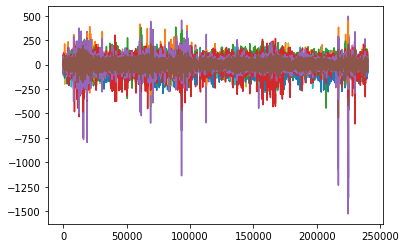

In [5]:
plt.plot(data)
plt.show()

### preprocessing data

In [6]:
read_dir = 'data/Pat1Train'
filenames = sorted(os.listdir(read_dir))
train_filenames = []
for filename in filenames:
    train_filenames.append(filename)
n = len(train_filenames)
image = loadmat(read_dir + '/' + train_filenames[0], squeeze_me=True)
X = np.zeros(((n,) + image['data'].shape), dtype='float32')
y = np.zeros(n, dtype='int8')

filename_to_idx = {}
for i, filename in enumerate(train_filenames):
    data= loadmat(read_dir + '/' + filename, squeeze_me=True)
    X[i] = data['data']
    y[i] = 1 if filename.endswith('_1.mat') else 0
    filename_to_idx['Pat1' + '/' + filename] = i

In [7]:
print(X.shape)
print(y.shape)
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

(826, 240000, 16)
(826,)


{0: 570, 1: 256}

### feature extraction

In [12]:
pat = 1
outfile = 'pat_'+str(pat)+'_feature_train.csv'

label = y

mydata = []
bands=[0.1,4,8,12,30,70,180]
rate = 400.
for i, x in tqdm(enumerate(X)):
        data_full = x.T
        output = []
        featureList = []
        featureList.append('Label')
        output.append(y[i])
        featureList.append('Pat')
        output.append(pat)
        data_full = data_full.astype(float)
        data = preprocessing.scale(data_full, axis=1,with_std=True)

        # get correlation Coef. this will be 16x16
        h=np.corrcoef(data)
        h=np.nan_to_num(h)
        # only want upper triangle
        ind = np.triu_indices(16, 1)
        htri = h[ind]
        for ii in range(np.size(htri)):
                featureList.append('coef%i'%(ii))
                output.append(htri[ii])


        # for j in range(19):
        #         data = data_full[:,j*int(rate*60/2):(j)*int(rate*60/2) + int(rate)*60]
        #         data = preprocessing.scale(data, axis=1,with_std=True)
                
        #         for k in range(16):
        #                 hold = data[k,:]
        #                 f,psd = spsig.welch(hold, fs=400, nperseg=2000)
        #                 psd = np.nan_to_num(psd)
        #                 psd /= psd.sum()
        #                 for c in range(1,len(bands)):
        #                         featureList.append('BandEnergy_%i_%i_%i'%(j,k,c))
        #                         output.append(psd[(f>bands[c-1])&(f<bands[c])].sum())


        mydata.append(pd.DataFrame({'Features':output},index=featureList).T)

trainSample = pd.concat(mydata,ignore_index=True)
trainSample.to_csv(outfile)


86it [00:18,  4.34it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
87it [00:19,  3.73it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
94it [00:20,  4.70it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
147it [00:32,  4.09it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
198it [00:43,  4.65it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeW

### test feature extraction and labels

In [40]:
test_csv = pd.read_csv('data/contest_test_data_labels_public.csv')

In [41]:
test_csv.head()

,image,class,usage
0,Pat1Test_1_0,0.0,Public
1,Pat1Test_2_0,NaN,Private
2,Pat1Test_3_0,1.0,Public
3,Pat1Test_4_0,NaN,Private
4,Pat1Test_5_0,NaN,Private


In [42]:
test_csv = test_csv[test_csv['usage'] == 'Public']
test_csv = test_csv.drop(['usage'], axis = 1)
test_labels = test_csv['class']
test_n = test_csv.shape[0]
test_csv = test_csv[test_csv["image"].str.contains("Pat2") == False]
test_csv = test_csv[test_csv["image"].str.contains("Pat3") == False]

In [44]:
read_dir = 'data/Pat1Test'

x_test = np.zeros(((test_n,) + (240000, 16)), dtype='float32')
y_test = np.zeros(test_n, dtype='int8')
filename_to_idx_test = {}

for index, row in test_csv.iterrows():
    datum = loadmat(read_dir + '/' + row['image'], squeeze_me=True)
    x_test[index] = datum['data']
    y_test[index] = row['class']
    filename_to_idx_test['Pat1' + '/' + row['image']] = i


(240000, 16)


In [47]:

mydata = []
bands=[0.1,4,8,12,30,70,180]
rate = 400.
outfile = 'pat_'+str(pat)+'_feature_test.csv'


for i, x in tqdm(enumerate(x_test)):
    data_full = x.T
    output = []
    featureList = []
    featureList.append('Label')
    output.append(y_test[i])
    featureList.append('Pat')
    output.append(pat)

    data_full = data_full.astype(float)
    data = preprocessing.scale(data_full, axis=1,with_std=True)

    # get correlation Coef. this will be 16x16
    h=np.corrcoef(data)
    h=np.nan_to_num(h)
    # only want upper triangle
    ind = np.triu_indices(16, 1)
    htri = h[ind]
    for ii in range(np.size(htri)):
            featureList.append('coef%i'%(ii))
            output.append(htri[ii])

    # for j in range(19):
    #                 data = data_full[:,j*int(rate*60/2):(j)*int(rate*60/2) + int(rate)*60]
    #                 data = preprocessing.scale(data, axis=1,with_std=True)
                    
    #                 for k in range(16):
    #                         hold = data[k,:]
    #                         f,psd = spsig.welch(hold, fs=400, nperseg=2000)
    #                         psd = np.nan_to_num(psd)
    #                         psd /= psd.sum()
    #                         for c in range(1,len(bands)):
    #                                 featureList.append('BandEnergy_%i_%i_%i'%(j,k,c))
    #                                 output.append(psd[(f>bands[c-1])&(f<bands[c])].sum())


    mydata.append(pd.DataFrame({'Features':output},index=featureList).T)
trainSample = pd.concat(mydata,ignore_index=True)
trainSample.to_csv(outfile)


1it [00:00,  4.12it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
3it [00:00,  4.31it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
4it [00:01,  3.41it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
6it [00:01,  4.06it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
7it [00:01,  4.31it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning:

### feature cleaning

In [49]:
features_train = pd.read_csv('pat_1_feature_train.csv')
features_test = pd.read_csv('pat_1_feature_test.csv')

In [50]:
features_train.head()

,Unnamed: 0,Label,Pat,coef0,coef1,coef2,coef3,coef4,coef5,coef6,...,coef110,coef111,coef112,coef113,coef114,coef115,coef116,coef117,coef118,coef119
0,0,0.0,1.0,0.428712,0.239288,-0.029995,-0.049008,-0.108267,-0.221111,-0.259864,...,-0.135339,-0.055649,-0.422350,0.363359,0.153373,0.143545,-0.162557,0.208065,-0.201821,0.125814
1,1,0.0,1.0,0.362774,0.176893,0.057885,0.033084,0.071525,-0.327772,0.006972,...,-0.184267,0.009362,-0.432038,-0.132126,0.171067,0.330142,-0.025839,0.155588,-0.289963,0.287685
2,2,1.0,1.0,-0.014333,-0.340122,-0.036219,0.138175,-0.008025,-0.566970,0.276999,...,-0.195962,-0.203428,0.457001,-0.032110,0.038336,-0.182046,0.400442,-0.283787,-0.296937,-0.192674
3,3,0.0,1.0,0.615629,0.341250,0.073276,0.178729,0.130639,-0.313140,-0.244894,...,-0.168334,-0.057750,-0.432701,0.077865,0.004979,0.253852,-0.007935,0.104957,-0.336854,0.313432
4,4,0.0,1.0,0.587197,0.352734,0.103082,0.179288,0.129077,-0.313195,-0.250147,...,-0.145239,-0.053936,-0.391708,0.128810,-0.060134,0.248877,0.041390,0.063769,-0.341966,0.297614


In [51]:
print(features_train.shape)
print(features_test.shape)

(826, 123)
(564, 123)


In [52]:
features_train.dropna(thresh=features_train.shape[1]-3, inplace=True)
features_train.replace([np.inf, -np.inf], np.nan, inplace=True)
features_train.fillna(0, inplace=True)

features_test.dropna(thresh=features_train.shape[1]-3, inplace=True)
features_test.replace([np.inf, -np.inf], np.nan, inplace=True)
features_test.fillna(0, inplace=True)

In [ ]:
label_train = features_train.Label.values
label_test = features_test.Label.values
x_train = features_train.drop(['Label', 'Pat', 'Unnamed: 0'], axis=1)
x_test= features_test.drop(['Label', 'Pat', 'Unnamed: 0'], axis=1)

### training

In [56]:
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [68]:
params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "eta": 0.22,
        "max_depth": 3,
        "subsample": 0.80,
        "colsample_bytree": 0.78,
        "silent": 1,
    }

dtrain=xgb.DMatrix(x_train,label_train)
model=xgb.train(params,dtrain,num_boost_round=500,verbose_eval=20)

[12:26:52] WARNING: /private/var/folders/h6/y3hp258s05s0fmq2lhy3v1800000gn/T/pip-install-cdc2w_yl/xgboost/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [72]:
test=xgb.DMatrix(x_test)
y_pred = model.predict(test)
auc = metrics.roc_auc_score(label_test, y_pred)
print ("AUC: " + str(auc))

AUC: 0.9616788321167883


<AxesSubplot:>

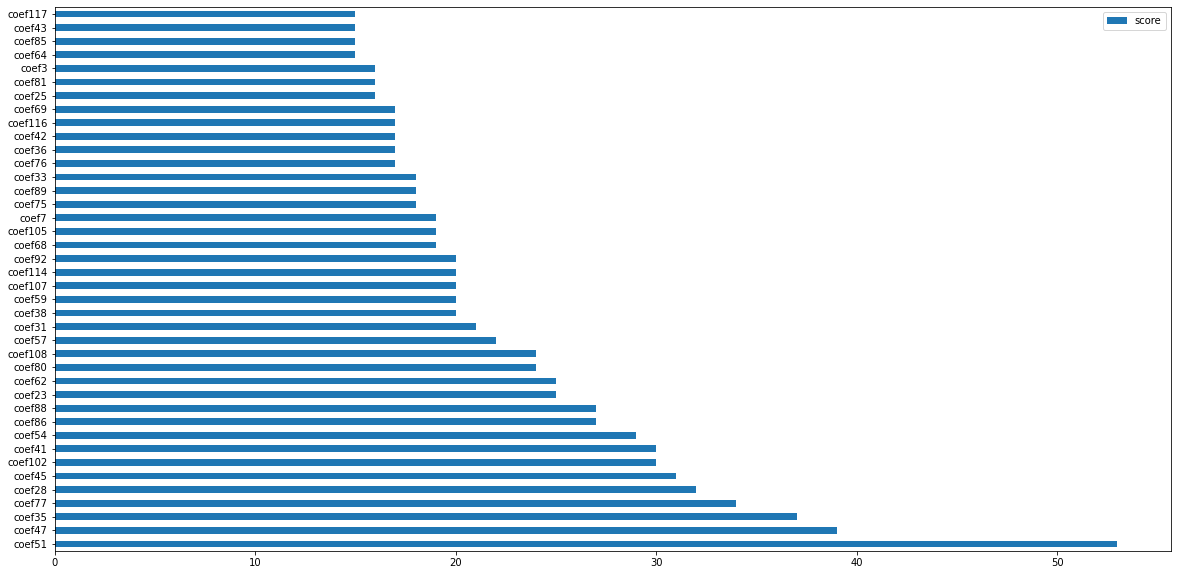

In [75]:
feature_important = model.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features